### Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
from sklearn import feature_extraction, linear_model, model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score,f1_score
from sklearn.feature_extraction.text import CountVectorizer
import torch
import matplotlib.pyplot as plt
import spacy
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

/Users/sonali/.local/share/virtualenvs/nlp_disaster_prediction-hxrhPPxI/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reading training dataset
train_df = pd.read_csv('/Users/sonali/Documents/Okstate/Spring\'24/CS5723_Spring\'24/Project/nlp-getting-started/train.csv')

In [3]:
# Printing the number of tweets in training dataset and sample 10 tweets
print(f'Number of training tweets: {train_df.shape[0]}\n')
display(train_df.sample(10))

Number of training tweets: 7613



,id,keyword,location,text,target
1297,1875,burning,NaN,You Bitches Walking Around Like Yall Hot Shit ...,0
7269,10407,whirlwind,Sheff/Bangor/Salamanca/Madrid,@VixMeldrew sounds like a whirlwind life!,0
161,232,airplane%20accident,Havenford,+ Nicole Fletcher one of a victim of crashed a...,1
5465,7799,quarantine,PA,Reddit Will Now Quarantine Offensive Content h...,0
5123,7307,nuclear%20reactor,japon,Germany has 39 gigawatts of installed solar c...,0
355,512,army,NaN,Vote for #Directioners vs #Queens in the 5th r...,0
623,896,bioterrorism,"Philadelphia, PA",@MeyerBjoern @thelonevirologi @MackayIM of a m...,1
4187,5949,hazard,NaN,Road Hazard @ CASCADE RD SW / CHILDRESS DR SW ...,0
2522,3625,desolation,infj,going to redo my nails and watch behind the sc...,1
4982,7108,military,Alaska,Mike Magner Discusses A Trust Betrayed: http:/...,0


In [4]:
# Setting target variable as 'labels' and text variable as 'train_text'.
labels = train_df['target'].values
train_text = train_df['text'].values

In [5]:
# Loading pre-trained Bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/Users/sonali/.local/share/virtualenvs/nlp_disaster_prediction-hxrhPPxI/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# Print the original tweet.
print(' Original: ', train_text[0])

# Print the tweet split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_text[0]))

# Print the sentence mapped to token ID's.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[0])))

 Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tokenized:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


In [7]:
# Checking the maximum length of tokenized 'text' so that we can pad all the input sequences to have the same length
max_len = 0
for text in train_text:    
    input_ids = tokenizer.encode(text, add_special_tokens=True)    
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  84


In [8]:
# Making list of sentence lenghts
token_lens = []
for text in train_text:
    tokens = tokenizer.encode(text, max_length = 512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


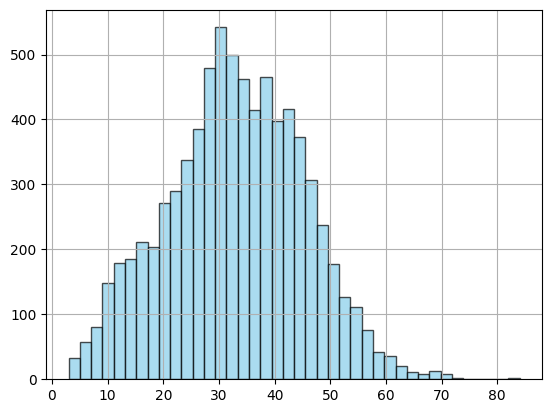

In [9]:
# Displaying sentence length distribution
plt.hist(token_lens, color='skyblue', bins = 40, edgecolor='black', alpha=0.7)
plt.grid(True)
plt.show()

In [10]:
# Defining a function which takes 'text' column and labels as input and returns encoded input ids and
# attention masks for each text along with target labels (all in tensor datatype)
def tokenize_map(sentence,labs):    
    global labels
    input_ids = []
    attention_masks = []
    for text in sentence:
        encoded_dict = tokenizer.encode_plus(text, add_special_tokens = True, truncation='longest_first',
                            max_length = 84, pad_to_max_length = True, return_attention_mask = True,
                            return_tensors = 'pt')
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

In [11]:
# Encoding all the sentences in the 'train_text' dataset using above defined function
input_ids, attention_masks, labels = tokenize_map(train_text, labels)

/Users/sonali/.local/share/virtualenvs/nlp_disaster_prediction-hxrhPPxI/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
# Combining the training inputs into a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

In [13]:
# Splitting above dataset into 80-20 'train' and 'validation' datasets
# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('training samples:', train_size)
print('validation samples:', val_size)

training samples: 6090
validation samples: 1523


In [14]:
# Using Dataloader to iterate over a dataset during training
# batch_size = 32 means 32 samples will be included in each batch during training
batch_size = 32
train_dataloader = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)

In [15]:
# Loading BertForSequenceClassification, the pretrained BERT model with a classification layer 
# built upon the original Bert model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels = 2, 
                                                      output_attentions = False, output_hidden_states = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Get all of the model's parameters as a list of tuples
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [17]:
# Using AdamW optimizer to update parameters during training
# AdamW is an adaptation of Adam with weight decay

optimizer = AdamW(model.parameters(), lr = 0.000006, eps = 0.00000001)

/Users/sonali/.local/share/virtualenvs/nlp_disaster_prediction-hxrhPPxI/lib/python3.11/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
# Choosing 3 epochs
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs] 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler to adjust the learning rate over time during training
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [19]:
# Defining functions to calculate accuracy score and AUC ROC score
def flat_accuracy(preds, labels):    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, pred_flat)

def flat_roc_auc(preds, labels):    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return roc_auc_score(labels_flat, pred_flat)

In [20]:
# Defining a function to train model
# Takes model, training dataloader, optimizer and scheduler as inputs and returns average training loss
def train_epoch(model, train_dataloader, optimizer, scheduler):
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]
        model.zero_grad()
        loss, logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels).to_tuple()
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    return avg_train_loss

In [21]:
# Defining a function to evaluate model
# Takes model and validation dataloader as inputs and returns average loss, average accuracy and average roc auc score
def evaluate(model, validation_dataloader):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    total_roc_auc = 0
    total_batches = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]
        with torch.no_grad():
            loss, logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels).to_tuple()
        total_loss += loss.item()
        logits = logits.detach().numpy()
        label_ids = b_labels.numpy()
        total_accuracy += flat_accuracy(logits, label_ids)
        total_roc_auc += flat_roc_auc(logits, label_ids)
        total_batches += 1

    avg_loss = total_loss / total_batches
    avg_accuracy = total_accuracy / total_batches
    avg_roc_auc = total_roc_auc / total_batches
    return avg_loss, avg_accuracy, avg_roc_auc

In [22]:
# Defining a function to train model; Returns training stats (average training loss, 
# validation loss, validation accuracy and validation ROC AUC score for each epoch)
def train_model(model, train_dataloader, validation_dataloader, optimizer, scheduler, epochs):
    training_stats = []

    for epoch_i in range(epochs):
        print('')
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        avg_train_loss = train_epoch(model, train_dataloader, optimizer, scheduler)
        print('  Average training loss: {0:.2f}'.format(avg_train_loss))

        print('')
        print('Running Validation...')
        avg_val_loss, avg_val_accuracy, avg_val_roc_auc = evaluate(model, validation_dataloader)
        print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
        print('  Roc Auc Score: {0:.2f}'.format(avg_val_roc_auc))
        print('  Validation Loss: {0:.2f}'.format(avg_val_loss))

        training_stats.append({
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_roc_auc': avg_val_roc_auc
        })

    print('')
    print('Training complete!')
    return training_stats

In [23]:
# Training model using above defined function
training_stats = train_model(model, train_dataloader, validation_dataloader, optimizer, scheduler, epochs)


======== Epoch 1 / 3 ========
Training...
  Average training loss: 0.51

Running Validation...
  Accuracy: 0.81
  Roc Auc Score: 0.81
  Validation Loss: 0.44

======== Epoch 2 / 3 ========
Training...
  Average training loss: 0.39

Running Validation...
  Accuracy: 0.82
  Roc Auc Score: 0.82
  Validation Loss: 0.42

======== Epoch 3 / 3 ========
Training...
  Average training loss: 0.35

Running Validation...
  Accuracy: 0.83
  Roc Auc Score: 0.82
  Validation Loss: 0.42

Training complete!


In [24]:
# Converting training_stats to dataframe and printing the dataframe
df_stats = pd.DataFrame(data=training_stats)
print(df_stats)

   epoch  Training Loss  Valid. Loss  Valid. Accur.  Val_roc_auc
0      1       0.505487     0.436149       0.813768     0.807380
1      2       0.389917     0.423631       0.822882     0.815090
2      3       0.353975     0.415006       0.828742     0.819409


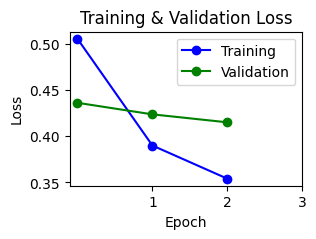

In [25]:
# Plotting the learning curve
fig, axes = plt.subplots(figsize=(3,2))
plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks([1, 2, 3])
plt.show()